# Sprint 2: Unsupervised learning

## Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re, string

rows_to_read = 500 # Gewenst aantal rijen inlezen (None = allemaal)

complaints = pd.read_csv('../data/complaints.csv', delimiter=',', nrows=rows_to_read)

rows, cols = complaints.shape

In [2]:
complaints.Product.unique()
complaints['Product'].nunique()

9

In totaal zijn er 9 verschillende producten, daarom is het doel om uiteindelijk 9 clusters te bekomen die elk
een product categorie voorstellen.

## Data pre-processing

In [3]:
complaints_df = complaints[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()

# Kolommen een simpelere naam geven
complaints_df.columns = ['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Narrative'] 
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative
0,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...
4,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...


In [4]:
# pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

def processing(string):
    # omzetten naar lowercase 
    string = string.lower()
    # alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]', '', string)
    # alle getallen eruit filteren
    string = re.sub(r'[0-9]|,', '', string)
    # returns en newlines eruithalen
    string = string.replace('\r', ' ')
    string = string.replace('\n', ' ')
    # kaartnummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}', ' ', string)
    # de string splitten om de stopwoorden er afzonderlijk uit te halen
    tokens = string.split(' ')
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS and len(w) > 3]
    ## werkwoord vervoegingen veranderen en woorden reduceren naar stamvorm
    result = [SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    return result

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
complaints_df['Narrative_Processed'] = complaints_df['Narrative'].apply(processing)

max_features gebruiken om enkel een vocubulair op te bouwen die bestaat uit de top max_features gesorteerd op term frequenctie over alle complaints. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens = complaints_df['Narrative_Processed'].astype('str')

#woorden die in meer dan 95% van de narratives voorkomen en woorden die in 5 of minder narratives voorkomen negeren 
#ook bigrams in rekening nemen
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,5),
                                    min_df = 2, 
                                    max_df = 0.1,
                                    max_features=10)

#dit zijn alle features
X = tfidf_vectorizer.fit_transform(tokens)
#target
y = complaints_df.head(10000)['Product'].values

print(X.shape)
print(y.shape)

In [24]:
feature_names=tfidf_vectorizer.get_feature_names()
print(feature_names[:10])
print(len(feature_names))
# #documenten,#features names (woorden in woordenboek)
print(X.shape)


['block', 'creditor', 'inquiri', 'insur', 'investig', 'mortgag', 'origin', 'section', 'theft', 'valid']
10
(500, 10)


## Data normalizeren

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray())
#scaled_data = pd.DataFrame(scaled_data)
X_scaled

array([[-0.18658996, -0.27098099, -0.28141635, ..., -0.1974559 ,
        -0.28133199, -0.28138056],
       [-0.18658996, -0.27098099, -0.28141635, ..., -0.1974559 ,
        -0.28133199, -0.28138056],
       [-0.18658996, -0.27098099, -0.28141635, ..., -0.1974559 ,
        -0.28133199, -0.28138056],
       ...,
       [-0.18658996,  4.46031691, -0.28141635, ..., -0.1974559 ,
        -0.28133199, -0.28138056],
       [-0.18658996, -0.27098099, -0.28141635, ..., -0.1974559 ,
         1.06599117, -0.28138056],
       [-0.18658996, -0.27098099, -0.28141635, ..., -0.1974559 ,
        -0.28133199, -0.28138056]])

## KMeans Clustering

### Niet Genormaliseerd

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# toepassen van kmeans op de woord frequenties per klacht
kmeans = KMeans(n_clusters=2).fit(X)

In [27]:
# Manier om de clusters te visualizeren (bron labo)
def plotClusters2D(data, cluster_labels, cluster_centers = None):  
    '''
    This function plots the data items, using a different color per cluster. If cluster_centers are provided, these are also plotted.
    
    Args:
    *  data: Numpy array of tuples: [[item1_x, item1_y], [item2_x, item2_y] ,... ]
    * cluster_labels: an array of integers containing the cluster number for each data item: 
    * cluster_centers: optional, an array of tuples containing the feature values of the cluster centers [[center1_x, center1_y], [center2_x,center 2_y]...]
    '''
    
    unique_labels = set(cluster_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
          # Black used for points not assigned to a cluster (will be useful for other algorithms, k-means assigns each element to a cluster)
          col = [0, 0, 0, 1]        

        plt.scatter(data[cluster_labels == k,0],data[cluster_labels == k,1],s=20,c=[col])

    if cluster_centers is not None:
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=250, marker='*', c='red', edgecolor='black')
  
    plt.xlabel('Feature 1') ;   
    plt.ylabel('Feature 2');

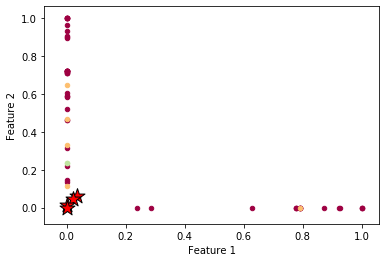

In [28]:
km = KMeans(n_clusters=4, init='k-means++')
y_km = km.fit_predict(X)
plotClusters2D(X.toarray(),y_km,km.cluster_centers_)


### Genormaliseerd

Normalizatie uitvoeren van tfidf

In [ ]:
km = KMeans(n_clusters=9, init='k-means++')
y_km = km.fit_predict(scaled_data)
plotClusters2D(X_scaled,y_km,km.cluster_centers_)

## DBSCAN

KMeans is gevoelig aan outliers, daarom wordt gewerkt met een methode die deze beter ondersteunt.

**DBSCAN - Density-Based Spatial Clustering** of applicaties met ruis. Dit bepaald de belangrijkste samples met een hoge densiteit en expandeert clusters van hen. Goed voor data die clusters bevat met een zelfde densiteit, daarom is het toepasselijk om analoge complaints te groeperen

* **eps**:  komt overeen met de maximale afstand tussen twee samples, die bepaald of de samples in dezelfde cluster liggen
      dit is de meest belangerijke parameter voor de distance functie en dataset
* **min_samples**: vanaf dit aantal is een groep samples een cluster

In [24]:
from sklearn.cluster import DBSCAN
import numpy as np
clustering = DBSCAN(eps=0.5, min_samples=1).fit(X_scaled)

In [ ]:
plotClusters2D(X_scaled,clustering.labels_)

In [ ]:
X